In [1]:
import numpy as np
import matplotlib.pylab as plt
import ipdb
import math
import time

%matplotlib inline

(32, 32, 4)


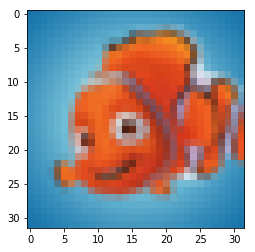

In [2]:
sample_file = '../input_data/nemo.ico'
sample_img = plt.imread(sample_file)
print (sample_img.shape)
plt.imshow(sample_img)

In [3]:
def plot(mat_lst):
    total = mat_lst.shape[2]
    row = int(math.sqrt(total))
    while (total % row != 0):
        row += 1
    col = int(total / row)

    f, ax = plt.subplots(row, col, figsize=(5,5))
    for i in range(row):
        for j in range(col):
            ax[i, j].imshow(mat_lst[:,:, i*col + j])
    plt.show()

In [4]:
# Activation Functions

def tanh(x):
    """Activation Function: tanh"""
    return np.tanh(x)

def sigmoid(num):
    """Activation Function: sigmoid"""
    x = 1.0 / (1 + np.exp(-num))
    return x

def ReLU(x):
    """Activation Function: ReLU"""
    return x * (x > 0)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    sum_den = e_x.sum(axis=0)
    return e_x / sum_den

# Part 1: Forward pass of LaNet architecture

In [5]:
class Network:
    def __init__(self):
        self.layers = []

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # predict output for given input
    def forward_pass(self, input_data):
        # forward propagation
        input = input_data
        for layer in self.layers:
            output = layer.forward_propagation(input)
            
            total = output.shape[2]
            r = int(math.sqrt(total))
            while (total % r != 0):
                r += 1
            c = int(total / r)
            plot(output, r, c)
            
            input = output

In [6]:
# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

In [7]:
# inherit from base class Layer
class ConvLayer(Layer):
    # input_shape = (i,j,d)
    # filter_shape = (m,n)
    # layer_depth = output_depth
    def __init__(self, input_shape, filter_shape, layer_depth, stride):
        self.input_shape = input_shape
        self.input_depth = input_shape[2]
        self.filter_shape = filter_shape
        self.layer_depth = layer_depth          # number of filters
        self.stride = stride
        self.output_shape = (int((input_shape[0]-filter_shape[0])/stride)+1, int((input_shape[1]-filter_shape[1])/stride)+1, layer_depth)
        self.weights = np.random.rand(filter_shape[0], filter_shape[1], self.input_depth, layer_depth) - 0.5
        self.bias = np.random.rand(layer_depth) - 0.5
        self.n_trainable_parameters = np.prod(np.array(self.weights.shape)) + np.prod(np.array(self.bias.shape))
        self.memory_used = np.prod(np.array(self.output_shape)) + self.n_trainable_parameters

    # returns output for a given input
    def forward_propagation(self, input):
        print ("Convolution Layer:\n input_shape: {}\n filter_shape: {}\n layer_depth: ({})\n stride: ({})\n output_shape: {}\n num_trainable parameters: ({})\n memory_used: ({})\n".\
                format(self.input_shape, self.filter_shape, self.layer_depth, self.stride, self.output_shape, self.n_trainable_parameters, self.memory_used))

        self.input = input
        self.output = np.zeros(self.output_shape)
        
        for k in range(self.layer_depth):
            for i in range(0, self.output_shape[0], self.stride):
                for j in range(0, self.output_shape[1], self.stride):
                    self.output[i,j,k] = np.sum(self.weights[:,:,:,k] * self.input[i:i+self.filter_shape[0], j:j+self.filter_shape[1], :]) + self.bias[k]

        return self.output

In [8]:
# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation):
        self.activation = activation
        self.n_trainable_parameters = 0
        self.memory_used = self.n_trainable_parameters

    # returns the activated input
    def forward_propagation(self, input):
        self.input = input
        self.output = self.activation(self.input)
        
        self.memory_used += np.prod(np.array(self.output.shape))
        
        print ("", self.activation.__doc__, "\n num_trainable_parameters: ({})\n memory_used: ({})".format(self.n_trainable_parameters, self.memory_used))
                
        return self.output

In [9]:
# inherit from base class Layer
class MaxPoolLayer(Layer):
    # input_shape = (i,j,d)
    # filter_shape = (m,n)
    # layer_depth = output_depth
    def __init__(self, input_shape, filter_shape, layer_depth, stride):
        self.input_shape = input_shape
        self.filter_shape = filter_shape
        self.layer_depth = layer_depth          # number of filters
        self.stride = stride
        self.output_shape = (int((input_shape[0]-filter_shape[0])/stride)+1, int((input_shape[1]-filter_shape[1])/stride)+1, layer_depth)
        self.n_trainable_parameters = 0
        self.memory_used = np.prod(np.array(self.output_shape)) + self.n_trainable_parameters

    # returns output for a given input
    def forward_propagation(self, input):
        print ("MaxPool Layer:\n input_shape: {}\n filter_shape: {}\n layer_depth: ({})\n stride: ({})\n output_shape: {}\n num_trainable_parameters: ({})\n memory_used: ({})".\
                format(self.input_shape, self.filter_shape, self.layer_depth, self.stride, self.output_shape, self.n_trainable_parameters, self.memory_used))

        self.input = input
        self.output = np.zeros(self.output_shape)

        for k in range(self.layer_depth):
            for i in range(0, self.input_shape[0], self.stride):
                for j in range(0, self.input_shape[1], self.stride):
                    ii = int(i/self.stride)
                    jj = int(j/self.stride)
                    self.output[ii,jj,k] = np.max(self.input[i:i+self.filter_shape[0], j:j+self.filter_shape[1], k])

        return self.output

In [10]:
# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5
        self.n_trainable_parameters = np.prod(np.array(self.weights.shape)) + np.prod(np.array(self.bias.shape))
        self.memory_used = self.n_trainable_parameters

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        
        self.memory_used += np.prod(np.array(self.output.shape))
        
        print ("Fully Connected Layer:\n input_size: {}\n output_size: {}\n num_trainable_parameters: ({})\n memory_used: ({})\n".\
                format(self.input_size, self.output_size, self.n_trainable_parameters, self.memory_used))
        
        return self.output

In [11]:
# inherit from base class Layer
class GaussianConnection(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5
        self.n_trainable_parameters = np.prod(np.array(self.weights.shape)) + np.prod(np.array(self.bias.shape))
        self.memory_used = self.n_trainable_parameters

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.array([np.sum((self.weights - self.input)**2 , axis = 0)]) + self.bias
        
        self.memory_used += np.prod(np.array(self.output.shape))
        
        print ("Gaussian Connection:\n input_size: {}\n output_size: {}\n num_trainable_paramters: ({})\n memory_used: ({})\n".\
                format(self.input_size, self.output_size, self.n_trainable_parameters, self.memory_used))
#         output_new =  output.reshape(output.shape[0],1) + self.bias
        
#         self.input = input_data
#         self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

### Activation Function: ReLU

C1
Convolution Layer:
 input_shape: (32, 32, 4)
 filter_shape: (5, 5)
 layer_depth: (6)
 stride: (1)
 output_shape: (28, 28, 6)
 num_trainable parameters: (606)
 memory_used: (5310)

 Activation Function: ReLU 
 num_trainable_parameters: (0)
 memory_used: (4704)


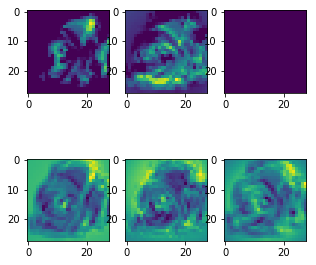

S2
MaxPool Layer:
 input_shape: (28, 28, 6)
 filter_shape: (2, 2)
 layer_depth: (6)
 stride: (2)
 output_shape: (14, 14, 6)
 num_trainable_parameters: (0)
 memory_used: (1176)


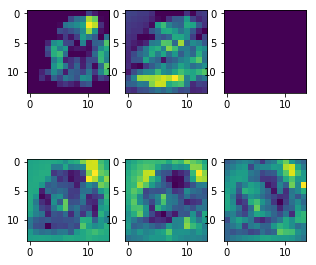

C3
Convolution Layer:
 input_shape: (14, 14, 6)
 filter_shape: (5, 5)
 layer_depth: (16)
 stride: (1)
 output_shape: (10, 10, 16)
 num_trainable parameters: (2416)
 memory_used: (4016)

 Activation Function: ReLU 
 num_trainable_parameters: (0)
 memory_used: (1600)


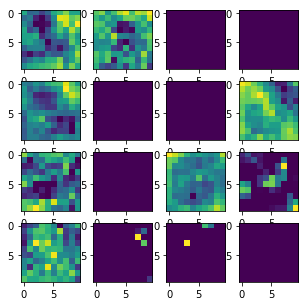

S4
MaxPool Layer:
 input_shape: (10, 10, 16)
 filter_shape: (2, 2)
 layer_depth: (16)
 stride: (2)
 output_shape: (5, 5, 16)
 num_trainable_parameters: (0)
 memory_used: (400)


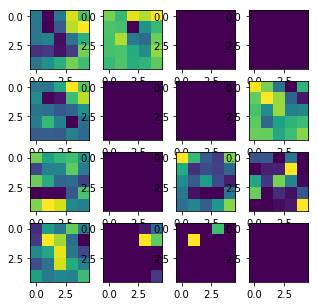

C5
Convolution Layer:
 input_shape: (5, 5, 16)
 filter_shape: (5, 5)
 layer_depth: (120)
 stride: (1)
 output_shape: (1, 1, 120)
 num_trainable parameters: (48120)
 memory_used: (48240)

F6
Fully Connected Layer:
 input_size: 120
 output_size: 84
 num_trainable_parameters: (10164)
 memory_used: (10248)

Gaussian Connection:
 input_size: 84
 output_size: 10
 num_trainable_paramters: (850)
 memory_used: (860)

Output of Softmax function:
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]

Memory used by Initial Convolutional Layers: 9326 units
Memory used by Fully Connected Layers: 58488 units


In [12]:
print ("C1")
C1 = ConvLayer(sample_img.shape, (5,5), 6, 1)
C1.forward_propagation(sample_img)
# C1 = ConvLayer(sample_img.shape, (5,5), 6, 1).forward_propagation(sample_img)
# plot(C1)

C1_act = ActivationLayer(ReLU)
C1_act.forward_propagation(C1.output)
plot(C1_act.output)

print ("S2")
S2 = MaxPoolLayer(C1_act.output.shape, (2,2), 6, 2)
S2.forward_propagation(C1_act.output)
plot(S2.output)

print ("C3")
C3 = ConvLayer(S2.output.shape, (5,5), 16, 1)
C3.forward_propagation(S2.output)
# plot(C2)
C3_act = ActivationLayer(ReLU)
C3_act.forward_propagation(C3.output)
plot(C3_act.output)

print ("S4")
S4 = MaxPoolLayer(C3_act.output.shape, (2,2), 16, 2)
S4.forward_propagation(C3_act.output)
plot(S4.output)

print ("C5")
C5 = ConvLayer(S4.output.shape, (5,5), 120, 1)
C5.forward_propagation(S4.output)
# print (conv3_output.shape)
# plot(conv3_output)

print ("F6")
F6 = FCLayer(120, 84)
F6.forward_propagation(C5.output[0])

GC = GaussianConnection(84, 10)
GC.forward_propagation(F6.output.T)
OUTPUT = softmax(GC.output.T)
print ("Output of Softmax function:")
print (OUTPUT)

conv_layers_memory = C1.memory_used + C3.memory_used
fc_layers_memory = C5.memory_used + F6.memory_used
print("\nMemory used by Initial Convolutional Layers:", conv_layers_memory, "units")
print("Memory used by Fully Connected Layers:", fc_layers_memory, "units")

# Part-2

### 1. What are the number of parameters in 1st convolutional layers ?

= Weight + Bias <br>
= (filter_rows * filter_cols * input_depth + bias) * No. of filters <br>
= (5 * 5 * 4 + 1) * 6 <br>
= (100 + 1) * 6 <br>
= 606

### 2. What are the number of parameters in pooling operation?

There are no trainable parameters in pooling operation

### 3. Which of the following operations contain most number of parameters?
(a) conv (b) pool (c) Fully Connected layer (FC) (d) Activation Functions

C1 - 606 parameters. <br>
S2 - 0 parameters. <br>
C3 - 2416 parameters. <br>
S4 - 0 parameters. <br>
C5 - 48120 parameters. <br>
F6 - 10164 parameters <br>
Gaussian connection - 850 parameters <br>
Activation Functions - 0 parameters. <br><br>
Thus , the fully connected layer "C5" contains the most number of parameters. <br>

### 4. Which operation consume most amount of memory?
(a) initial convolution layers (b) fully connected layers at the end

As shown above, <br>
Memory used by initial convolution layers = 9326 units <br>
Memory used by fully connected layers = 58488 unit <br><br>
Hence, (b) fully connected layers at the end, consumes the most amount of memory.

### 5. Try different activation functions and describe observations.

**Note:** Activation Function "ReLU" is used above. <br>

#### Activation Function: tanh

C1
Convolution Layer:
 input_shape: (32, 32, 4)
 filter_shape: (5, 5)
 layer_depth: (6)
 stride: (1)
 output_shape: (28, 28, 6)
 num_trainable parameters: (606)
 memory_used: (5310)

 Activation Function: tanh 
 num_trainable_parameters: (0)
 memory_used: (4704)


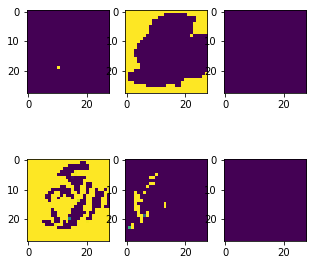

S2
MaxPool Layer:
 input_shape: (28, 28, 6)
 filter_shape: (2, 2)
 layer_depth: (6)
 stride: (2)
 output_shape: (14, 14, 6)
 num_trainable_parameters: (0)
 memory_used: (1176)


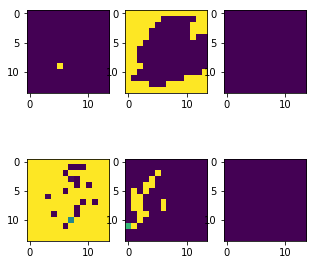

C3
Convolution Layer:
 input_shape: (14, 14, 6)
 filter_shape: (5, 5)
 layer_depth: (16)
 stride: (1)
 output_shape: (10, 10, 16)
 num_trainable parameters: (2416)
 memory_used: (4016)

 Activation Function: tanh 
 num_trainable_parameters: (0)
 memory_used: (1600)


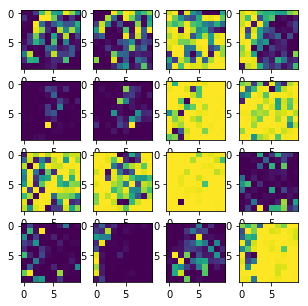

S4
MaxPool Layer:
 input_shape: (10, 10, 16)
 filter_shape: (2, 2)
 layer_depth: (16)
 stride: (2)
 output_shape: (5, 5, 16)
 num_trainable_parameters: (0)
 memory_used: (400)


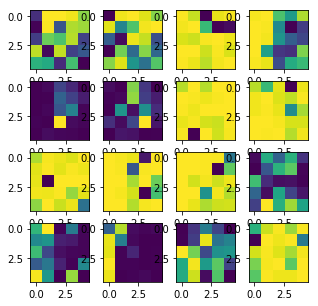

C5
Convolution Layer:
 input_shape: (5, 5, 16)
 filter_shape: (5, 5)
 layer_depth: (120)
 stride: (1)
 output_shape: (1, 1, 120)
 num_trainable parameters: (48120)
 memory_used: (48240)

F6
Fully Connected Layer:
 input_size: 120
 output_size: 84
 num_trainable_parameters: (10164)
 memory_used: (10248)

Gaussian Connection:
 input_size: 84
 output_size: 10
 num_trainable_paramters: (850)
 memory_used: (860)

Output of Softmax function:
[[4.87950977e-046]
 [2.43548901e-079]
 [2.16213304e-013]
 [3.81819024e-104]
 [3.84794062e-053]
 [2.63864542e-089]
 [1.00000000e+000]
 [2.91181305e-052]
 [1.73774584e-060]
 [9.20202640e-037]]

Memory used by Initial Convolutional Layers: 9326 units
Memory used by Fully Connected Layers: 58488 units


In [13]:
print ("C1")
C1 = ConvLayer(sample_img.shape, (5,5), 6, 1)
C1.forward_propagation(sample_img)
# C1 = ConvLayer(sample_img.shape, (5,5), 6, 1).forward_propagation(sample_img)
# plot(C1)

C1_act = ActivationLayer(tanh)
C1_act.forward_propagation(C1.output)
plot(C1_act.output)

print ("S2")
S2 = MaxPoolLayer(C1_act.output.shape, (2,2), 6, 2)
S2.forward_propagation(C1_act.output)
plot(S2.output)

print ("C3")
C3 = ConvLayer(S2.output.shape, (5,5), 16, 1)
C3.forward_propagation(S2.output)
# plot(C2)
C3_act = ActivationLayer(tanh)
C3_act.forward_propagation(C3.output)
plot(C3_act.output)

print ("S4")
S4 = MaxPoolLayer(C3_act.output.shape, (2,2), 16, 2)
S4.forward_propagation(C3_act.output)
plot(S4.output)

print ("C5")
C5 = ConvLayer(S4.output.shape, (5,5), 120, 1)
C5.forward_propagation(S4.output)
# print (conv3_output.shape)
# plot(conv3_output)

print ("F6")
F6 = FCLayer(120, 84)
F6.forward_propagation(C5.output[0])

GC = GaussianConnection(84, 10)
GC.forward_propagation(F6.output.T)
OUTPUT = softmax(GC.output.T)
print ("Output of Softmax function:")
print (OUTPUT)

conv_layers_memory = C1.memory_used + C3.memory_used
fc_layers_memory = C5.memory_used + F6.memory_used
print("\nMemory used by Initial Convolutional Layers:", conv_layers_memory, "units")
print("Memory used by Fully Connected Layers:", fc_layers_memory, "units")

#### Activation Function: sigmoid

C1
Convolution Layer:
 input_shape: (32, 32, 4)
 filter_shape: (5, 5)
 layer_depth: (6)
 stride: (1)
 output_shape: (28, 28, 6)
 num_trainable parameters: (606)
 memory_used: (5310)

 Activation Function: sigmoid 
 num_trainable_parameters: (0)
 memory_used: (4704)


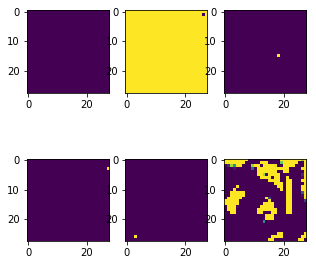

S2
MaxPool Layer:
 input_shape: (28, 28, 6)
 filter_shape: (2, 2)
 layer_depth: (6)
 stride: (2)
 output_shape: (14, 14, 6)
 num_trainable_parameters: (0)
 memory_used: (1176)


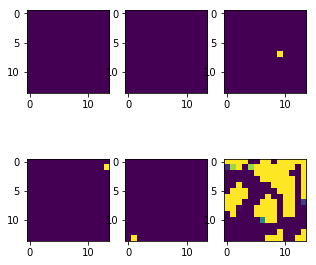

C3
Convolution Layer:
 input_shape: (14, 14, 6)
 filter_shape: (5, 5)
 layer_depth: (16)
 stride: (1)
 output_shape: (10, 10, 16)
 num_trainable parameters: (2416)
 memory_used: (4016)

 Activation Function: sigmoid 
 num_trainable_parameters: (0)
 memory_used: (1600)


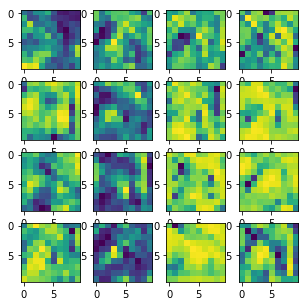

S4
MaxPool Layer:
 input_shape: (10, 10, 16)
 filter_shape: (2, 2)
 layer_depth: (16)
 stride: (2)
 output_shape: (5, 5, 16)
 num_trainable_parameters: (0)
 memory_used: (400)


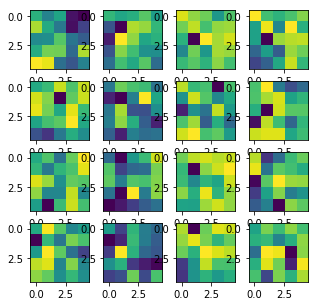

C5
Convolution Layer:
 input_shape: (5, 5, 16)
 filter_shape: (5, 5)
 layer_depth: (120)
 stride: (1)
 output_shape: (1, 1, 120)
 num_trainable parameters: (48120)
 memory_used: (48240)

F6
Fully Connected Layer:
 input_size: 120
 output_size: 84
 num_trainable_parameters: (10164)
 memory_used: (10248)

Gaussian Connection:
 input_size: 84
 output_size: 10
 num_trainable_paramters: (850)
 memory_used: (860)

Output of Softmax function:
[[4.68040606e-27]
 [5.02127927e-76]
 [1.04409802e-31]
 [2.06798285e-09]
 [9.99999998e-01]
 [3.06523030e-33]
 [4.74256160e-78]
 [2.82529351e-22]
 [8.77674746e-55]
 [1.40169212e-44]]

Memory used by Initial Convolutional Layers: 9326 units
Memory used by Fully Connected Layers: 58488 units


In [164]:
print ("C1")
C1 = ConvLayer(sample_img.shape, (5,5), 6, 1)
C1.forward_propagation(sample_img)
# C1 = ConvLayer(sample_img.shape, (5,5), 6, 1).forward_propagation(sample_img)
# plot(C1)

C1_act = ActivationLayer(sigmoid)
C1_act.forward_propagation(C1.output)
plot(C1_act.output)

print ("S2")
S2 = MaxPoolLayer(C1_act.output.shape, (2,2), 6, 2)
S2.forward_propagation(C1_act.output)
plot(S2.output)

print ("C3")
C3 = ConvLayer(S2.output.shape, (5,5), 16, 1)
C3.forward_propagation(S2.output)
# plot(C2)
C3_act = ActivationLayer(sigmoid)
C3_act.forward_propagation(C3.output)
plot(C3_act.output)

print ("S4")
S4 = MaxPoolLayer(C3_act.output.shape, (2,2), 16, 2)
S4.forward_propagation(C3_act.output)
plot(S4.output)

print ("C5")
C5 = ConvLayer(S4.output.shape, (5,5), 120, 1)
C5.forward_propagation(S4.output)
# print (conv3_output.shape)
# plot(conv3_output)

print ("F6")
F6 = FCLayer(120, 84)
F6.forward_propagation(C5.output[0])

GC = GaussianConnection(84, 10)
GC.forward_propagation(F6.output.T)
OUTPUT = softmax(GC.output.T)
print ("Output of Softmax function:")
print (OUTPUT)

conv_layers_memory = C1.memory_used + C3.memory_used
fc_layers_memory = C5.memory_used + F6.memory_used
print("\nMemory used by Initial Convolutional Layers:", conv_layers_memory, "units")
print("Memory used by Fully Connected Layers:", fc_layers_memory, "units")